In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [2]:
df = pd.read_csv('data/preprocessed_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label'], inplace=True)
df.head()


,TaskName,BOdoNum,Make,Model,Year,FuelType,EngineSize,Transmission,DriveType,IsHybrid,Distance,Months,AdjustedPrice
1,Logbook Service,72199.0,SKODA,SKODA FABIA III,2017,Petrol,1.0,Auto,NaN,0.0,75000.0,60.0,710.0
4,Logbook Service,81168.0,MAZDA,MAZDA CX-9,2018,Petrol,2.5,Auto,2WD,0.0,80000.0,96.0,586.0
5,Capped Price Service,40008.0,HYUNDAI,HYUNDAI KONA,2019,Petrol,1.6,Auto,4WD,0.0,40000.0,NaN,354.0
6,Capped Price Service,95200.0,HYUNDAI,HYUNDAI TUCSON,2019,Diesel,2.0,Auto,4WD,0.0,90000.0,NaN,499.0
7,Park Light Globe Replacement,95200.0,HYUNDAI,HYUNDAI TUCSON,2019,Diesel,2.0,Auto,4WD,0.0,NaN,NaN,7.0


In [3]:
counts = df['VMakeModel'].value_counts()
to_drop = counts[counts < 100].index
df = df[~df['VMakeModel'].isin(to_drop)]
df['VMakeModel'].value_counts()

VMakeModel
FORD RANGER          18934
TOYOTA HILUX         14114
TOYOTA COROLLA       11424
TOYOTA RAV4           9552
TOYOTA HIACE          8601
                     ...  
TOYOTA GRANVIA         104
KIA EV6                102
GWM UTE                102
RENAULT KOLEOS II      101
TOYOTA AURION          101
Name: count, Length: 160, dtype: int64

In [4]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Identify feature types
cat_features = X_train.select_dtypes(include=["object", "category"]).columns


In [7]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")


for col in X_test.select_dtypes(include='object').columns:
   X_test[col] = X_test[col].fillna("missing")

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
cat_feature_indices = [0, 1]
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [500, 1000]
}

model = CatBoostRegressor(iterations=1000, cat_features=cat_feature_indices, verbose=0)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=25, cv=3, scoring='neg_mean_absolute_percentage_error')

random_search.fit(X_train, y_train, 
                  verbose=False)

best_model = random_search.best_estimator_



print("Best params:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Best params: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 6}
Best score: 0.18321784240898706


In [10]:


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


MAE: 84.00342206586689
RMSE: 128.56310240083891
MAPE: 17.97%


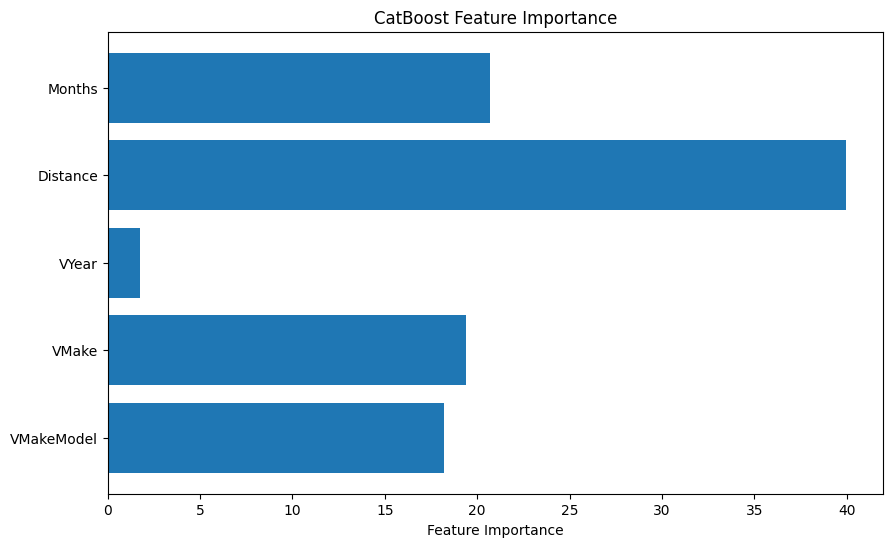

In [11]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()